# TAREA NO. 3 - ESTADÍSTICA MULTIVARIADA: REGRESIÓN MULTIVARIADA

## Descripción de la base de datos
Este conjutno de datos contiene seis meses de datos de consumo eléctrico de un hogar, recogidos entre enero y junio de 2007. Los datos incluyen información sobre potencia activa global, potencia reactiva global, tensión, intensidad global, submedición 1 (cocina), submedición 2 (lavadero) y submedición 3 (calentador de agua eléctrico y aire acondicionado). Con 260.640 mediciones en total, el objetivo es predecir o estimar el consumo eléctrico de los hogares.

| Nombre de la columna | Descripción |
| --- | --- |
| Fecha | La fecha de la observación. (Fecha) |
| Hora | La hora de la observación. (Hora) |
| Potencia_activa_global | La potencia activa total consumida por el hogar (kilovatios). (Numérico) |
| Potencia_reactiva_global | La potencia reactiva total consumida por el hogar (kilovatios). (Numérico) |
| Voltaje | El voltaje al cual se entrega la electricidad al hogar (voltios). (Numérico) |
| Intensidad_global | La intensidad de corriente promedio entregada al hogar (amperios). (Numérico) |
| Sub_medición_1 | La potencia activa consumida por la cocina (kilovatios). (Numérico) |
| Sub_medición_2 | La potencia activa consumida por la lavandería (kilovatios). (Numérico) |
| Sub_medición_3 | La potencia activa consumida por el calentador de agua eléctrico y el aire acondicionado (kilovatios). (Numérico) |

La variable respuesta para el modelo de regresión múltiple es la potencia aparente global en la red. A priori, esta variable no está incluida dentro del conjunto de datos, por lo que es necesario obtenerla a parir de la potencia reactiva y activa global que si están disponibles en el conjunto de datos.

In [1]:
# Importar las librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Preprocesamiento de los datos

### 1.1. Preparación de la base de datos con las variables predictoras y la variable respuesta

In [2]:
def date_to_semester_fraction(date):
    """ Se convierte la fecha a un valor entre 0 y 1 que representa el semestre en el que se encuentra la fecha

    Args:
        date (str): Fecha en formato 'dd/mm/yyyy'

    Returns:
        float: Fracción del semestre en el que se encuentra
    """
    day, month, year = map(int, date.split('/'))
    days_in_month = [31, 28, 31, 30, 31, 30]
    day_of_year = sum(days_in_month[:month - 1]) + day
    return day_of_year / 182

In [3]:
# Preprocesamiento de los datos
df = pd.read_csv('household_power_consumption.csv')
df = df.replace('?', np.nan)
df = df.dropna()
df['day_frac'] = df['Time'].apply(lambda x: (int(x.split(':')[0]) * 3600 + int(x.split(':')[1]) * 60 + int(x.split(':')[2])) / 86400)
df['semester_frac'] = df['Date'].apply(date_to_semester_fraction)
df = df.drop(['index', 'Date', 'Time'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 256869 entries, 0 to 260639
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Global_active_power    256869 non-null  object 
 1   Global_reactive_power  256869 non-null  object 
 2   Voltage                256869 non-null  object 
 3   Global_intensity       256869 non-null  object 
 4   Sub_metering_1         256869 non-null  object 
 5   Sub_metering_2         256869 non-null  object 
 6   Sub_metering_3         256869 non-null  float64
 7   day_frac               256869 non-null  float64
 8   semester_frac          256869 non-null  float64
dtypes: float64(3), object(6)
memory usage: 19.6+ MB


En este caso, al no tratarse de un modelo pensado para series de tiempo (lo cual sería ideal para este tipo de bases de datos ya que los datos presentan patrones estacionales), se optó por convertir las variables de fecha y tiempo en variables numéricas de la siguiente forma: i) para la fecha, se consideró el tiempo de desde enero de 2007 hasta junio de 2007, que es un semestre, como el 100% del tiempo, por lo que la columna de feca ahora es un valor entre 0.0 y 1.0 que representa el porcentaje del semestre que ha transcurrido; ii) el tiempo tiene un análisis similar, pero ahora se considera es el porcentaje del día que ha transcurrido, esto debido a que la base de datos esta compuesta por muestras tomadas en cada minuto el día durante los 6 meses.

In [4]:
# Conversión de los datos a float
for col in df.columns:
    df[col] = df[col].astype(float)
    
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 256869 entries, 0 to 260639
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Global_active_power    256869 non-null  float64
 1   Global_reactive_power  256869 non-null  float64
 2   Voltage                256869 non-null  float64
 3   Global_intensity       256869 non-null  float64
 4   Sub_metering_1         256869 non-null  float64
 5   Sub_metering_2         256869 non-null  float64
 6   Sub_metering_3         256869 non-null  float64
 7   day_frac               256869 non-null  float64
 8   semester_frac          256869 non-null  float64
dtypes: float64(9)
memory usage: 19.6 MB


In [5]:
# Se calcula la potencia aparente global a partir de la potencia activa y reactiva usando la fórmula S = sqrt(P^2 + Q^2)
df['Global_apparent_power'] = np.sqrt(df['Global_active_power'] ** 2 + df['Global_reactive_power'] ** 2)
df.drop(['Global_active_power', 'Global_reactive_power'], axis=1, inplace=True)

La potencia aparente se calcula a partir de la potencia reactiva y activa como la raíz de la suma de estas componentes al cuadrado como se muestra en la imagen:

In [6]:
from IPython.display import Image
Image(url= "https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEic9D1dQVBXgZ-fxxRSRj-_P7lt_BmaEN7pMRtQ61d2tJFni3JTcGlwf1HZdggjAozWL6xHH5HpbXPVTXRrngbO7nxhLOsTUlP9r4NUznCOOy278Ufg96I4LzMMSfgxHs4DuIoR7HUnKpI6/s1600/triangulo.png", width=600, height=400)

In [7]:
df

,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day_frac,semester_frac,Global_apparent_power
0,241.97,10.6,0.0,0.0,0.0,0.000000,0.005495,2.583582
1,241.75,10.4,0.0,0.0,0.0,0.000694,0.005495,2.553958
2,241.64,10.4,0.0,0.0,0.0,0.001389,0.005495,2.551960
3,241.71,10.4,0.0,0.0,0.0,0.002083,0.005495,2.551960
4,241.98,10.4,0.0,0.0,0.0,0.002778,0.005495,2.555957
...,...,...,...,...,...,...,...,...
260635,239.01,12.0,0.0,0.0,18.0,0.996528,0.994505,2.902413
260636,238.86,12.2,0.0,0.0,17.0,0.997222,0.994505,2.914074
260637,239.05,12.0,0.0,0.0,18.0,0.997917,0.994505,2.895570
260638,238.98,11.2,0.0,0.0,18.0,0.998611,0.994505,2.675762


### 1.2. Obtención de los valores X e y para entrenar al modelo de regresión

In [8]:
y = df['Global_apparent_power'].to_numpy()
X = df.drop('Global_apparent_power', axis=1).to_numpy()

X.shape, y.shape

((256869, 7), (256869,))

Finalmente, el conjunto de datos es un conjunto de 256.869 observaciones con 7 variables predictoras y una sola variable respuesta que estima el consumo en una casa a partir de las mediciones hechas en diferentes áreas de la casa.

El reto en este caso es estimar ese consumo considerando que hay algunas mediciones no tomadas en cuenta, como, por ejemplo, algunas cargas inductivas o capacitivas que producen una componente reactiva de la potencia y que no se ve reflejada en los medidores (ya que estos solo miden potencia activa). Además, podría haber otros medidores que no fueron tenidos en cuenta o habitaciones que no fueron monitoreadas.

## 2. Creación del Modelo de Regresión Multiple Lineal

### 2.1 Proceso de validacion cruzada

In [9]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [10]:
# Importar las librerias necesarias para regresión multiple lineal con regularización Lasso
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold

# Se realiza una validación cruzada para encontrar los mejores hiperparámetros
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_scores = pd.DataFrame(columns=['alpha', 'max_iter', 'tol', 'mae', 'n_zeros'])

# Proceso e validación cruzada con diferentes hiperparámetros (alpha, max_iter, tol)
for alpha in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]:
    for max_iter in [100, 1000, 10000]:
        for tol in [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]:
            scores = []
            for train_index, test_index in kf.split(X):
                # Dividir los datos en entrenamiento y prueba
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                
                # Definir el modelo Lasso
                model = Lasso(alpha=alpha, max_iter=max_iter, tol=tol)
                
                # Entrenar el modelo
                model.fit(X_train, y_train)
                
                # Realizar predicciones
                preds = model.predict(X_test)
                
                # Calcular el error medio absoluto
                mae = np.mean(np.abs(preds - y_test))
                scores.append(mae)
                
                # Contar el número de coeficientes iguales a cero para evaluar la regularización
                n_zeros = np.sum(model.coef_ == 0).astype(int)
                
            # Guardar los resultados de la validación cruzada para análisis posterior
            kf_scores.loc[len(kf_scores)] = [alpha, max_iter, tol, np.mean(scores), n_zeros]

### 2.2. Elección del mejor modelo (en terminos del error) vs. el modelo con la menor cantidad de preictores

In [11]:
# Se ordenan los resultados de la validación cruzada por el error absoluto medio
a = kf_scores.sort_values(by='mae')
a

,alpha,max_iter,tol,mae,n_zeros
39,0.0001,1000.0,1.000000e-08,0.026480,0.0
47,0.0001,10000.0,1.000000e-08,0.026480,0.0
31,0.0001,100.0,1.000000e-08,0.026480,0.0
30,0.0001,100.0,1.000000e-07,0.026480,0.0
38,0.0001,1000.0,1.000000e-07,0.026480,0.0
...,...,...,...,...,...
126,1.0000,100.0,1.000000e-07,0.159717,5.0
142,1.0000,10000.0,1.000000e-07,0.159717,5.0
127,1.0000,100.0,1.000000e-08,0.159717,5.0
135,1.0000,1000.0,1.000000e-08,0.159717,5.0


In [12]:
print('Hay', np.unique(a['n_zeros']), 'valores de nulos')

Hay [0. 2. 4. 5.] valores de nulos


In [13]:
alpha = (a['mae'].max() / len(a)) / np.max(np.unique(a['n_zeros']))
alpha

0.00022182913997166433

In [14]:
def get_best_n_zeros(num, extract_best=False):
    """ Se obtiene el mejor resultado segun la cantidad de nulos

    Args:
        num (int): Número de nulos

    Returns:
        float: Mejor valor de nulos
    """
    if extract_best:
        return a[a['n_zeros'] == num].sort_values(by='mae').iloc[0]
    else:
        return a[a['n_zeros'] == num].sort_values(by='mae').iloc[0]['mae']

In [15]:
e = []
for i in np.unique(a['n_zeros']):
    print(f'Mejor valor para {i} coeficientes nulos es: {get_best_n_zeros(i):.3f} Watts', end='\n')
    e.append(get_best_n_zeros(i))

Mejor valor para 0.0 coeficientes nulos es: 0.026 Watts
Mejor valor para 2.0 coeficientes nulos es: 0.026 Watts
Mejor valor para 4.0 coeficientes nulos es: 0.027 Watts
Mejor valor para 5.0 coeficientes nulos es: 0.032 Watts


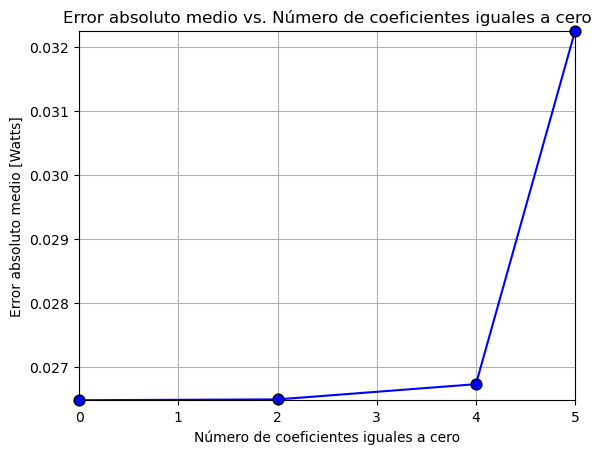

In [16]:
plt.figure()
plt.scatter(np.unique(a['n_zeros']), e, s=60, c='b', edgecolor='black', zorder=3, clip_on=False)
plt.plot(np.unique(a['n_zeros']), e, c='b', zorder=2)
plt.xlabel('Número de coeficientes iguales a cero')
plt.ylabel('Error absoluto medio [Watts]')
plt.title('Error absoluto medio vs. Número de coeficientes iguales a cero')
plt.xlim(np.min(a['n_zeros']), np.max(a['n_zeros']))
plt.ylim(np.min(e), np.max(e))
plt.grid()
plt.show()

Error para 0.000 coeficientes iguales a cero: 0.026 Watts: E=0.02803
Error para 2.000 coeficientes iguales a cero: 0.026 Watts: E=0.02760
Error para 4.000 coeficientes iguales a cero: 0.027 Watts: E=0.02740
Error para 5.000 coeficientes iguales a cero: 0.032 Watts: E=0.03270

Mejor número de coeficientes iguales a cero: 4.0


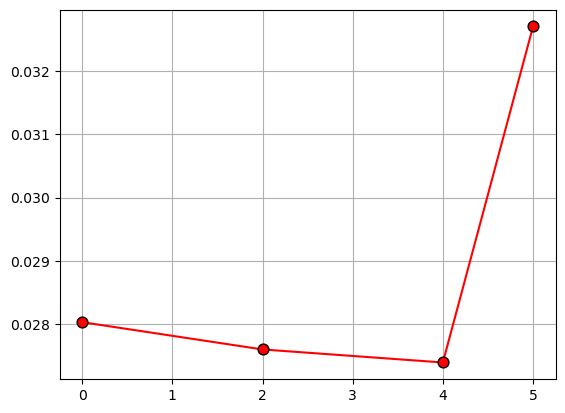

In [17]:
# Calcular error por predictor diferente de cero
best_n = -1
E = []
for i, j in zip(e, np.unique(a['n_zeros'])):
    print(f'Error para {j:.3f} coeficientes iguales a cero: {i:.3f} Watts: E={i + (X.shape[1] - j) * alpha:.5f}')
    E.append(i + (X.shape[1] - j) * alpha)
    if E[-1] == np.min(E):
        best_n = j
        
print(f'\nMejor número de coeficientes iguales a cero: {best_n}')

plt.figure()
plt.scatter(np.unique(a['n_zeros']), E, s=60, c='r', edgecolor='black', zorder=3, clip_on=False)
plt.plot(np.unique(a['n_zeros']), E, c='r')
plt.grid()
plt.show()

El modelo de regresión múltiple lineal que tiene mejor desempeño en relación con la menor cantidad de predictores se obtiene usando la siguiente métrica: El máximo error obtenido durante todos los entrenamientos se divide entre el numero total de entrenamientos. Este valor a su vez se divide entre el número máximo de predictores con un factor de 0.0. Este resultado se denomina Alpha. Con este valor, se calcula la suma entre el mejor error obtenido con x cantidad de predictores en cero, y la multiplicación entre el número de predictores diferentes de cero y Alpha. Esta métrica da como resultado el mejor modelo en relación error/número de predictores diferentes de cero.

El mejor modelo en este caso es el siguiente:

In [18]:
best_model = get_best_n_zeros(best_n, extract_best=True)
best_model = {
    'alpha': best_model['alpha'],
    'max_iter': int(best_model['max_iter']),
    'tol': best_model['tol']
}
best_model

{'alpha': 0.01, 'max_iter': 1000, 'tol': 0.001}

### 2.3. Validación del modelo y significancia de los predictores

In [19]:
model_def = Lasso(**best_model)
model_def.fit(X, y)

preds = model_def.predict(X_test)
mae = np.mean(np.abs(preds - y_test))
print(f'Error absoluto medio en el conjunto de prueba: {mae:.3f} Watts')

Error absoluto medio en el conjunto de prueba: 0.027 Watts


El error medido en los datos de test que estuvieron aislados dl entrenamiento todo el tiempo son consistentes con el error obtenido en la etapa de búsqueda de parámetros del modelo, lo que indica no hay sobre-entrenamiento en el modelo.

In [20]:
print(f'Coeficientes del modelo: {model_def.coef_}')
print(f'Intercepto del modelo: {model_def.intercept_}')

Coeficientes del modelo: [ 0.00348367  0.23377931 -0.         -0.          0.00188205  0.
 -0.        ]
Intercepto del modelo: -0.8248227841280986


In [21]:
from scipy import stats

# Número de observaciones y predictores
n, p = X.shape

# Coeficientes del modelo
coef = model_def.coef_

# Error estándar de los coeficientes
y_pred = model_def.predict(X)
residuals = y - y_pred
rss = np.sum(residuals ** 2)
stderr = np.sqrt(rss / (n - p - 1)) / np.sqrt(np.sum((X - np.mean(X, axis=0)) ** 2, axis=0))

# Estadísticos t y p-valores
t_stats = coef / stderr
p_values = [2 * (1 - stats.t.cdf(np.abs(t), df=n - p - 1)) for t in t_stats]

# Mostrar resultados
for i, col in enumerate(df.columns[:-1]):
    print(f'{col}: coef={coef[i]:.4f}, t={t_stats[i]:.4f}, p={p_values[i]:.4f}')

Voltage: coef=0.0035, t=136.2199, p=0.0000
Global_intensity: coef=0.2338, t=12731.5055, p=0.0000
Sub_metering_1: coef=-0.0000, t=-0.0000, p=1.0000
Sub_metering_2: coef=-0.0000, t=-0.0000, p=1.0000
Sub_metering_3: coef=0.0019, t=167.6585, p=0.0000
day_frac: coef=0.0000, t=0.0000, p=1.0000
semester_frac: coef=-0.0000, t=-0.0000, p=1.0000


En este caso, estableciendo un valor de significancia del 5% (0.05), los valores p que son menores a este umbral se consideran estadísticamente significativos, siendo el voltaje, corriente y la medición del medidor 3 ubicado en la habitación con el calentador y el aire acondicionado, que es donde mayor consumo hay. Los demás predictores no son estadísticamente significativos, por lo que el modelo Lasso no los consideró.